In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [10]:
data = pd.read_csv('connectome_data.csv')
data = data.drop(columns=['node_id', 'dn_position_x', 'dn_position_y', 'dn_position_z', 'dn_region', 'dn_hemisphere', 'dn_correspondence_id', 'dn_name'])
data['dn_fsname'] = [label.split('_')[0] for label in data['dn_fsname']]
X = data.drop(columns=['dn_fsname'])
y = data['dn_fsname']

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [12]:
X.head()

,deg_cent,clo_cent,betw_cent,eig_cent,evec1,evec2,evec3,evec4,evec5,evec6,evec7,evec8,evec9,evec10
0,-1.004064,-1.143290,0.003176,-0.840298,0.277870,0.092176,-0.468575,-0.011661,-17.835484,-7.858731,-1.000373,-0.999779,-0.994243,0.003182
1,-1.041514,-2.196688,-0.218531,-0.868578,0.200364,0.072607,-0.376161,-0.011331,-17.584311,-7.808582,-1.000529,-1.040027,-1.059466,0.003329
2,-0.030373,0.589077,-0.117750,0.388600,0.986038,0.238240,-1.131687,-0.004748,-0.494349,0.486810,0.141230,0.602832,0.926079,0.005540
3,1.692312,0.876054,0.276130,2.054865,1.592230,0.373575,-1.752596,0.001632,-0.290340,0.317795,0.104422,0.723024,1.045321,0.002175
4,-0.966614,-0.981269,-0.218531,-0.751858,0.328180,0.084954,-0.410423,-0.001800,-0.135438,0.152326,0.047149,0.229556,0.368045,0.002999


In [13]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=22)

In [14]:
data.head()

,dn_fsname,deg_cent,clo_cent,betw_cent,eig_cent,evec1,evec2,evec3,evec4,evec5,evec6,evec7,evec8,evec9,evec10
0,parstriangularis,0.002759,0.269117,0.002759,0.000783,0.010035,0.003349,-0.016940,-0.000352,-0.643506,-0.283561,-0.036111,-0.036021,-0.035831,0.000069
1,parsopercularis,0.001379,0.212112,0.000000,0.000013,0.007239,0.002643,-0.013606,-0.000340,-0.634444,-0.281751,-0.036116,-0.037473,-0.038184,0.000074
2,parsopercularis,0.038621,0.362863,0.001254,0.034249,0.035585,0.008619,-0.040864,-0.000103,-0.017850,0.017541,0.005078,0.021800,0.033453,0.000154
3,parsopercularis,0.102069,0.378392,0.006155,0.079626,0.057456,0.013502,-0.063266,0.000128,-0.010489,0.011443,0.003750,0.026137,0.037755,0.000033
4,parsopercularis,0.004138,0.277884,0.000000,0.003191,0.011850,0.003088,-0.014842,0.000004,-0.004900,0.005473,0.001683,0.008333,0.013319,0.000062


In [15]:
unique_values, counts = np.unique(y_encoded, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f"{value} occurs {count} times")

0 occurs 1056 times
1 occurs 555 times
2 occurs 839 times
3 occurs 1064 times
4 occurs 1064 times
5 occurs 1063 times
6 occurs 1064 times
7 occurs 1064 times
8 occurs 613 times
9 occurs 863 times
10 occurs 1064 times
11 occurs 1064 times
12 occurs 1062 times
13 occurs 1064 times
14 occurs 1064 times
15 occurs 11464 times
16 occurs 11512 times
17 occurs 25414 times
18 occurs 14759 times
19 occurs 60 times
20 occurs 41 times
21 occurs 25379 times
22 occurs 49968 times
23 occurs 11320 times
24 occurs 31068 times
25 occurs 13832 times
26 occurs 43092 times
27 occurs 4032 times
28 occurs 33064 times
29 occurs 954 times
30 occurs 11315 times
31 occurs 23983 times
32 occurs 6722 times
33 occurs 18920 times
34 occurs 158 times
35 occurs 7594 times
36 occurs 15403 times
37 occurs 52982 times
38 occurs 19126 times
39 occurs 73274 times
40 occurs 46551 times
41 occurs 5047 times
42 occurs 34124 times
43 occurs 84806 times
44 occurs 58727 times
45 occurs 20501 times
46 occurs 42058 times
47 occurs

In [19]:
# Define the model
model = XGBClassifier(random_state=22)

# Define parameter grid for RandomizedSearchCV
param_dist = {
    "n_estimators": [50, 100, 150],
    "max_depth": [6, 10, 12],
    "subsample": [0.6, 0.7, 0.8, 1.0],
}

# RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
random_search = RandomizedSearchCV(
    model, param_distributions=param_dist, scoring='accuracy', n_iter=20, cv=cv, random_state=22, n_jobs=-1, verbose=3
)
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print Train/Test Accuracy
train_acc = accuracy_score(y_train, best_model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END max_depth=10, n_estimators=100, subsample=1.0;, score=0.380 total time= 9.3min
[CV 3/5] END max_depth=12, n_estimators=100, subsample=0.8;, score=0.392 total time=12.9min
[CV 4/5] END max_depth=12, n_estimators=100, subsample=0.8;, score=0.392 total time=13.0min
[CV 1/5] END max_depth=12, n_estimators=100, subsample=0.8;, score=0.393 total time=13.0min
[CV 5/5] END max_depth=12, n_estimators=100, subsample=0.8;, score=0.393 total time=13.0min
[CV 2/5] END max_depth=12, n_estimators=100, subsample=0.8;, score=0.391 total time=13.1min
[CV 2/5] END max_depth=10, n_estimators=100, subsample=1.0;, score=0.379 total time=10.4min
[CV 4/5] END max_depth=12, n_estimators=150, subsample=0.8;, score=0.402 total time=19.9min
[CV 5/5] END max_depth=12, n_estimators=150, subsample=0.8;, score=0.403 total time=19.9min
[CV 2/5] END max_depth=12, n_estimators=150, subsample=0.8;, score=0.401 total time=20.0min
[CV 3/5] END max_d

/Users/shamanthk/Documents/Research/IS-modeling-connectomes/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/5] END max_depth=12, n_estimators=100, subsample=0.6;, score=0.386 total time= 8.2min
[CV 5/5] END max_depth=12, n_estimators=100, subsample=0.6;, score=0.385 total time= 8.2min
[CV 3/5] END max_depth=6, n_estimators=150, subsample=0.8;, score=0.358 total time= 6.3min
[CV 4/5] END max_depth=6, n_estimators=150, subsample=0.8;, score=0.358 total time= 6.4min
[CV 3/5] END max_depth=12, n_estimators=50, subsample=0.7;, score=0.367 total time= 4.0min
[CV 2/5] END max_depth=12, n_estimators=50, subsample=0.7;, score=0.370 total time= 4.0min
[CV 4/5] END max_depth=12, n_estimators=50, subsample=0.7;, score=0.368 total time= 4.0min
[CV 5/5] END max_depth=6, n_estimators=150, subsample=0.8;, score=0.358 total time= 6.4min
[CV 5/5] END max_depth=12, n_estimators=50, subsample=0.7;, score=0.368 total time= 4.0min
[CV 1/5] END max_depth=6, n_estimators=150, subsample=1.0;, score=0.357 total time= 6.1min
[CV 2/5] END max_depth=6, n_estimators=150, subsample=1.0;, score=0.356 total time= 6.2m

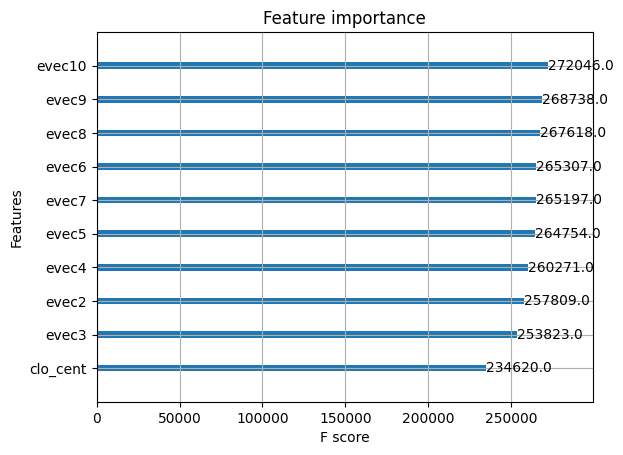

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.show()

In [ ]:
data.shape

(817382, 15)

In [ ]:
from sklearn.metrics import classification_report

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=2))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.57      0.63       213
           1       0.21      0.10      0.13       105
           2       0.30      0.11      0.16       175
           3       0.67      0.67      0.67       209
           4       0.57      0.50      0.53       217
           5       0.38      0.13      0.20       191
           6       0.61      0.57      0.59       209
           7       0.79      0.76      0.77       222
           8       0.39      0.31      0.35       123
           9       0.20      0.11      0.15       160
          10       0.70      0.67      0.68       228
          11       0.61      0.56      0.58       219
          12       0.48      0.22      0.30       219
          13       0.66      0.72      0.69       205
          14       0.73      0.72      0.72       218
          15       0.16      0.04      0.06      2304
          16       0.42      0.33      0.37      2293
    

/Users/shamanthk/Documents/Research/IS-modeling-connectomes/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shamanthk/Documents/Research/IS-modeling-connectomes/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shamanthk/Documents/Research/IS-modeling-connectomes/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

print("Class to Label Mapping:")
for original_class, encoded_label in label_mapping.items():
    print(f"{original_class} -> {encoded_label}")

Class to Label Mapping:
Brain-Stem -> 0
Left-Accumbens-area -> 1
Left-Amygdala -> 2
Left-Caudate -> 3
Left-Hippocampus -> 4
Left-Pallidum -> 5
Left-Putamen -> 6
Left-Thalamus-Proper -> 7
Right-Accumbens-area -> 8
Right-Amygdala -> 9
Right-Caudate -> 10
Right-Hippocampus -> 11
Right-Pallidum -> 12
Right-Putamen -> 13
Right-Thalamus-Proper -> 14
bankssts -> 15
caudalanteriorcingulate -> 16
caudalmiddlefrontal -> 17
cuneus -> 18
entorhinal -> 19
frontalpole -> 20
fusiform -> 21
inferiorparietal -> 22
inferiortemporal -> 23
insula -> 24
isthmuscingulate -> 25
lateraloccipital -> 26
lateralorbitofrontal -> 27
lingual -> 28
medialorbitofrontal -> 29
middletemporal -> 30
paracentral -> 31
parahippocampal -> 32
parsopercularis -> 33
parsorbitalis -> 34
parstriangularis -> 35
pericalcarine -> 36
postcentral -> 37
posteriorcingulate -> 38
precentral -> 39
precuneus -> 40
rostralanteriorcingulate -> 41
rostralmiddlefrontal -> 42
superiorfrontal -> 43
superiorparietal -> 44
superiortemporal -> 45


In [21]:
import pickle

with open('trained_models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)